# Deriving Offensive Line Effectiveness from Tracking Data

This is the code that accompanies my submission for the [NFL Big Data Bowl 2023](https://www.kaggle.com/code/mattlowrieds/offensive-line-effectiveness-from-tracking-data). In this notebook I look at several metrics derived from tracking data which can give insight into offensive line effectiveness in stopping a pass rush by the defense.

# Preprocessing

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from pandarallel import pandarallel
pandarallel.initialize()

NFL_RED = '#D50A0A'
NFL_BLUE = '#013369'

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# Files from the Kaggle dataset:
# https://www.kaggle.com/competitions/nfl-big-data-bowl-2023/data
games_df = pd.read_csv('games.csv')
plays_df = pd.read_csv('plays.csv')
scout_df = pd.read_csv('pffScoutingData.csv')
# NOTE: loading all tracking data uses ~3.8GB of RAM
dfs = []
for i in range(1, 9):
    dfs.append(pd.read_csv(f'week{i}.csv'))
track_df = pd.concat(dfs, ignore_index=True)
del dfs

In [3]:
# Get all gameId/playId combinations in the tracking data as tuples.
# This data is saved as a Series, because it needs to retain the same
# number of rows as the original DataFrame to be used as an indexer with isin().
track_gp_combos = track_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)

In [4]:
# Get all gameId/playId combinations in the scouting and play data as tuples.
scout_gp_combos = scout_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)
plays_gp_combos = plays_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)

In [5]:
# Get the nflId for each pass rusher and blocker in each play of every game
pass_rush_ids_gb = scout_df.loc[scout_df['pff_role'] == 'Pass Rush'].groupby(['gameId', 'playId', 'nflId'])

# Sack plays
Since the role of the offensive line is to protect the quarterback, a play that results in the quarterback being sacked can be interpreted as an instance where the offensive line was ineffective. If we look at several metrics from sack plays, such as the average speed and average acceleration of pass rushers, as well as the distance traveled by pass rushers, we can see that these metrics are higher on sack plays when compared to all other plays. This suggests that these metrics can give us a bit of insight into how effective the offensive line is performing.

In [6]:
# Create a GroupBy object of all the gameId/playId combinations which result in a sack
sacks_gp_gb = scout_df.loc[scout_df['pff_sack'] == 1].groupby(['gameId', 'playId'])

In [7]:
# Get the tracking data for all sack and nonsack plays
track_sacks_df = track_df.loc[track_gp_combos.isin(sacks_gp_gb.groups.keys())]
track_nonsacks_df = track_df.loc[~track_gp_combos.isin(sacks_gp_gb.groups.keys())]

In [8]:
# Get all gameId/playId/nflId combinations in the tracking data as tuples
# for sack and nonsack plays
sacks_gpn_combos = track_sacks_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)
nonsacks_gpn_combos = track_nonsacks_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)

In [9]:
# Get the count of pass rushers for sack and nonsack plays
track_sacks_prs_df = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]
num_sack_prs = len(track_sacks_prs_df[['gameId', 'playId', 'nflId']].drop_duplicates().index)
track_nonsacks_prs_df = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]
num_nonsack_prs = len(track_nonsacks_prs_df[['gameId', 'playId', 'nflId']].drop_duplicates().index)

In [10]:
# Compute statistics for sack and nonsack plays
sacks_avg_speed = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
sacks_avg_accel = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
sacks_sum_dist = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
sacks_dist_per_pr = sacks_sum_dist/num_sack_prs

nonsacks_avg_speed = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
nonsacks_avg_accel = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
nonsacks_sum_dist = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
nonsacks_dist_per_pr = nonsacks_sum_dist/num_nonsack_prs

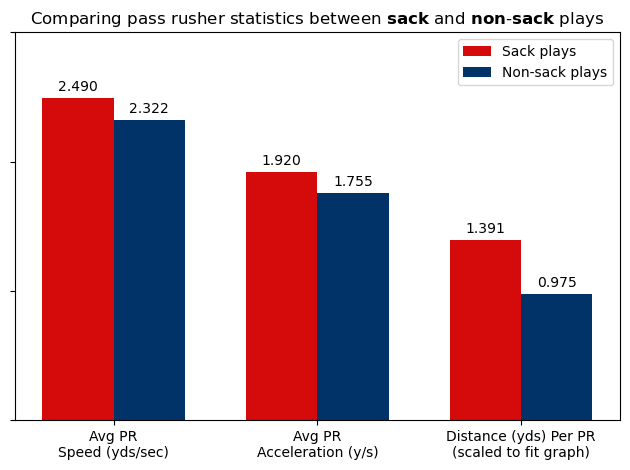

In [11]:
x_lbls = ['Avg PR\nSpeed (yds/sec)', 'Avg PR\nAcceleration (y/s)',
          'Distance (yds) Per PR\n(scaled to fit graph)']
x_range = np.arange(len(x_lbls))
sacks_vals = [sacks_avg_speed, sacks_avg_accel, sacks_dist_per_pr/10]
nonsacks_vals = [nonsacks_avg_speed, nonsacks_avg_accel, nonsacks_dist_per_pr/10]

bar_width = 0.35
fig, ax = plt.subplots()
bars_sacks = ax.bar(x_range - bar_width/2, sacks_vals, bar_width, label='Sack plays', color=NFL_RED)
bars_nonsacks = ax.bar(x_range + bar_width/2, nonsacks_vals, bar_width, label='Non-sack plays', color=NFL_BLUE)
ax.bar_label(bars_sacks, padding=3, fmt='%.3f')
ax.bar_label(bars_nonsacks, padding=3, fmt='%.3f')
ax.set_xticks(x_range, x_lbls)
ax.set_yticks(np.arange(ax.get_ylim()[1]+0.5), [])
ax.legend()
plt.title(r'Comparing pass rusher statistics between $\bf{sack}$ and $\bf{non}$-$\bf{sack}$ plays')
fig.tight_layout()
plt.show()

# Hurry plays
Likewise on plays where the quarterback was hurried, and which resulted in no yardage gain on the play, we can interpret these plays as the offensive line being ineffective as well. For these plays, we can see the same metrics are all higher than other plays.

In [12]:
# Create a GroupBy object of all the gameId/playId combinations which result in a hurry play
hurry_gp_gb = scout_df.loc[scout_df['pff_hurry'] == 1].groupby(['gameId', 'playId'])

# Next lookup all hurry plays with a playResult less than 1 yard
hurry_lt1yd_gp_gb = plays_df.loc[(plays_gp_combos.isin(hurry_gp_gb.groups.keys())) &
                                 (plays_df['playResult'] < 1)].groupby(['gameId', 'playId'])

In [13]:
track_hurry_df = track_df.loc[track_gp_combos.isin(hurry_lt1yd_gp_gb.groups.keys())]
track_nonhurry_df = track_df.loc[~track_gp_combos.isin(hurry_lt1yd_gp_gb.groups.keys())]

In [14]:
hurry_gpn_combos = track_hurry_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)
nonhurry_gpn_combos = track_nonhurry_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)

In [15]:
track_hurry_prs_df = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]
num_hurry_prs = len(track_hurry_prs_df[['gameId', 'playId', 'nflId']].drop_duplicates().index)
track_nonhurry_prs_df = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]
num_nonhurry_prs = len(track_nonhurry_prs_df[['gameId', 'playId', 'nflId']].drop_duplicates().index)

In [16]:
hurry_avg_speed = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
hurry_avg_accel = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
hurry_sum_dist = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
hurry_dist_per_pr = hurry_sum_dist/num_hurry_prs

nonhurry_avg_speed = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
nonhurry_avg_accel = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
nonhurry_sum_dist = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
nonhurry_dist_per_pr = nonhurry_sum_dist/num_nonhurry_prs

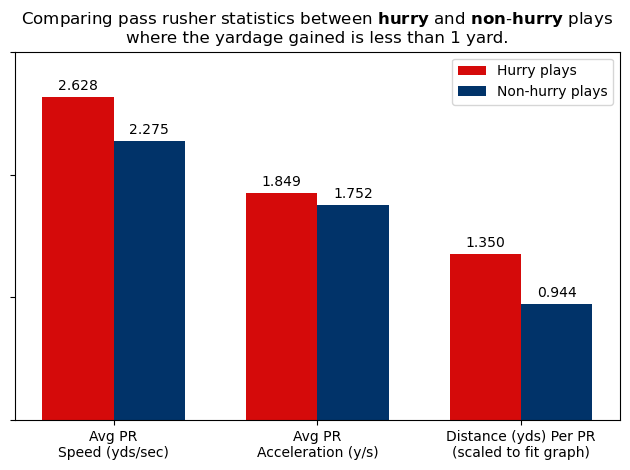

In [17]:
x_lbls = ['Avg PR\nSpeed (yds/sec)', 'Avg PR\nAcceleration (y/s)',
          'Distance (yds) Per PR\n(scaled to fit graph)']
x_range = np.arange(len(x_lbls))
dist_graph_scale_factor = 100000
hurry_vals = [hurry_avg_speed, hurry_avg_accel, hurry_dist_per_pr/10]
nonhurry_vals = [nonhurry_avg_speed, nonhurry_avg_accel, nonhurry_dist_per_pr/10]

bar_width = 0.35
fig, ax = plt.subplots()
bars_hurry = ax.bar(x_range - bar_width/2, hurry_vals, bar_width, label='Hurry plays', color=NFL_RED)
bars_nonhurry = ax.bar(x_range + bar_width/2, nonhurry_vals, bar_width, label='Non-hurry plays', color=NFL_BLUE)
ax.bar_label(bars_hurry, padding=3, fmt='%.3f')
ax.bar_label(bars_nonhurry, padding=3, fmt='%.3f')
ax.set_xticks(x_range, x_lbls)
ax.set_yticks(np.arange(ax.get_ylim()[1]+0.5), [])
ax.legend()
plt.title(r'Comparing pass rusher statistics between $\bf{hurry}$ and $\bf{non}$-$\bf{hurry}$ plays'
          '\nwhere the yardage gained is less than 1 yard.')
fig.tight_layout()
plt.show()

# Completed pass plays
If the previous analysis holds true, then these same metrics should be lower for plays that result in a completed pass, meaning the offensive line was effective in protecting the quarterback to successfully execute the play. From the data we can see this is true.

In [18]:
passc_gp_gb = plays_df.loc[plays_df['passResult'] == 'C'].groupby(['gameId', 'playId'])

track_passc_df = track_df.loc[track_gp_combos.isin(passc_gp_gb.groups.keys())]
track_nonpassc_df = track_df.loc[~track_gp_combos.isin(passc_gp_gb.groups.keys())]

passc_gpn_combos = track_passc_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)
nonpassc_gpn_combos = track_nonpassc_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)

In [19]:
track_passc_prs_df = track_passc_df.loc[passc_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]
num_passc_prs = len(track_passc_prs_df[['gameId', 'playId', 'nflId']].drop_duplicates().index)
track_nonpassc_prs_df = track_nonpassc_df.loc[nonpassc_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]
num_nonpassc_prs = len(track_nonpassc_prs_df[['gameId', 'playId', 'nflId']].drop_duplicates().index)

In [20]:
passc_avg_speed = track_passc_df.loc[passc_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
passc_avg_accel = track_passc_df.loc[passc_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
passc_sum_dist = track_passc_df.loc[passc_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
passc_dist_per_pr = passc_sum_dist/num_passc_prs

nonpassc_avg_speed = track_nonpassc_df.loc[nonpassc_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
nonpassc_avg_accel = track_nonpassc_df.loc[nonpassc_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
nonpassc_sum_dist = track_nonpassc_df.loc[nonpassc_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
nonpassc_dist_per_pr = nonpassc_sum_dist/num_nonpassc_prs

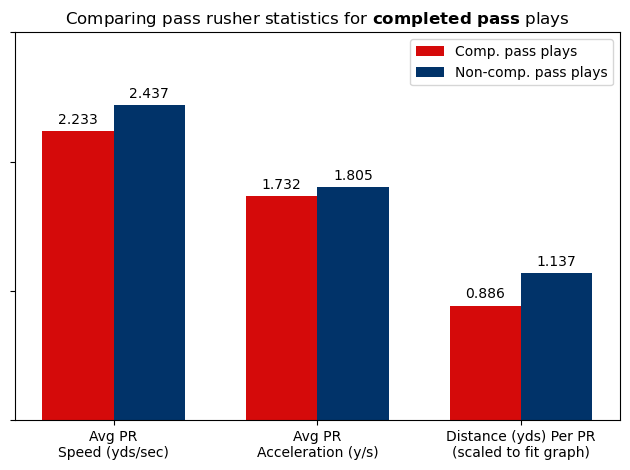

In [21]:
x_lbls = ['Avg PR\nSpeed (yds/sec)', 'Avg PR\nAcceleration (y/s)',
          'Distance (yds) Per PR\n(scaled to fit graph)']
x_range = np.arange(len(x_lbls))
dist_graph_scale_factor = 100000
passc_vals = [passc_avg_speed, passc_avg_accel, passc_dist_per_pr/10]
nonpassc_vals = [nonpassc_avg_speed, nonpassc_avg_accel, nonpassc_dist_per_pr/10]

bar_width = 0.35
fig, ax = plt.subplots()
bars_passc = ax.bar(x_range - bar_width/2, passc_vals, bar_width, label='Comp. pass plays', color=NFL_RED)
bars_nonpassc = ax.bar(x_range + bar_width/2, nonpassc_vals, bar_width, label='Non-comp. pass plays', color=NFL_BLUE)
ax.bar_label(bars_passc, padding=3, fmt='%.3f')
ax.bar_label(bars_nonpassc, padding=3, fmt='%.3f')
ax.set_xticks(x_range, x_lbls)
ax.set_yticks(np.arange(ax.get_ylim()[1]+0.5), [])
ax.legend()
plt.title(r'Comparing pass rusher statistics for $\bf{completed}$ $\bf{pass}$ plays')
fig.tight_layout()
plt.show()

# Collecting per team metrics
Now we can collect each of these metrics for each team from the complete dataset of tracking data.

In [22]:
def collect_offensive_team_metrics(r):
    gid, pid = r
    # Get an array of nflIds for all pass rushers for this play
    pass_rush_ids = scout_df.loc[(scout_df['gameId'] == gid) &
                                 (scout_df['playId'] == pid) &
                                 (scout_df['pff_role'] == 'Pass Rush')]['nflId'].to_numpy()
    # Don't count plays where there are no pass rushers
    if len(pass_rush_ids) == 0:
        return pd.Series([np.nan]*4, index=['team', 's', 'a', 'dis'])
    # Get the team of pass rushers. This is returned as array but should only contain one team.
    pr_team = track_df.loc[(track_df['gameId'] == gid) &
                           (track_df['playId'] == pid) &
                           (track_df['nflId'] == pass_rush_ids[0])]['team'].to_numpy()
    # Get the string value of the defensive team. There should only be 1 entry.
    defense_team = np.unique(pr_team)[0]
    # Get both teams in this game to figure out which team is offense
    game_teams = games_df.loc[games_df['gameId'] == gid][['homeTeamAbbr', 'visitorTeamAbbr']].values
    offense_team = ''
    if len(game_teams):
        for gt in game_teams[0]:
            if gt != defense_team:
                offense_team = gt
    # Get the average speed and acceleration of the pass rushers as a Series
    pr_speed_accel_sr = track_df.loc[(track_df['gameId'] == gid) &
                                     (track_df['playId'] == pid) &
                                     (track_df['nflId'].isin(pass_rush_ids))][['s', 'a']].mean()
    # Get the total distance of the pass rushers as a Series
    pr_dist_sr = track_df.loc[(track_df['gameId'] == gid) &
                              (track_df['playId'] == pid) &
                              (track_df['nflId'].isin(pass_rush_ids))][['dis']].sum()
    return pd.concat([pd.Series(np.unique(offense_team), index=['team']),
                      pr_speed_accel_sr,
                      pr_dist_sr, 
                      pd.Series(len(pass_rush_ids), index=['num_prs'])])

gps = track_gp_combos.drop_duplicates()
offense_team_metrics_gp_df = gps.parallel_apply(collect_offensive_team_metrics)
offense_team_metrics_gp_df.dropna(inplace=True)

In [23]:
offensive_team_stats = {}
for t in track_df['team'].unique():
    if t != 'football':
        avg_speed = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['s'].mean()
        avg_accel = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['a'].mean()
        num_pass_rushers = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['num_prs'].sum()
        dist_per_play = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['dis'].sum()/num_pass_rushers
        offensive_team_stats[t] = [avg_speed, avg_accel, dist_per_play]

# Ranking
To rank each team based on these metrics, we can calculate the z-score to see where each team falls in the distribution for each metric. We can then calculate a final score for ranking by taking the average of all z-scores.

In [24]:
stats_data = np.array([offensive_team_stats[t] for t in offensive_team_stats.keys()])
speed_avg = stats_data[:, 0].mean()
speed_std = stats_data[:, 0].std()
accel_avg = stats_data[:, 1].mean()
accel_std = stats_data[:, 1].std()
dist_avg = stats_data[:, 2].mean()
dist_std = stats_data[:, 2].std()

In [25]:
offensive_team_scores = {}
for team, stats in offensive_team_stats.items():
    speed_z = (stats[0] - speed_avg) / speed_std
    accel_z = (stats[1] - accel_avg) / accel_std
    dist_z = (stats[2] - dist_avg) / dist_std
    score = np.mean([speed_z, accel_z, dist_z])
    offensive_team_scores[score] = team

# Results
Based on these metrics alone, the scoring shows that the Eagles had the most effective offensive line against passing plays for the first 8 weeks of the 2021 season. While these metrics certainly aren't comprehensive, they can potentially be used along with other commonly used metrics to get an overall perspective when evaluating offensive lines.

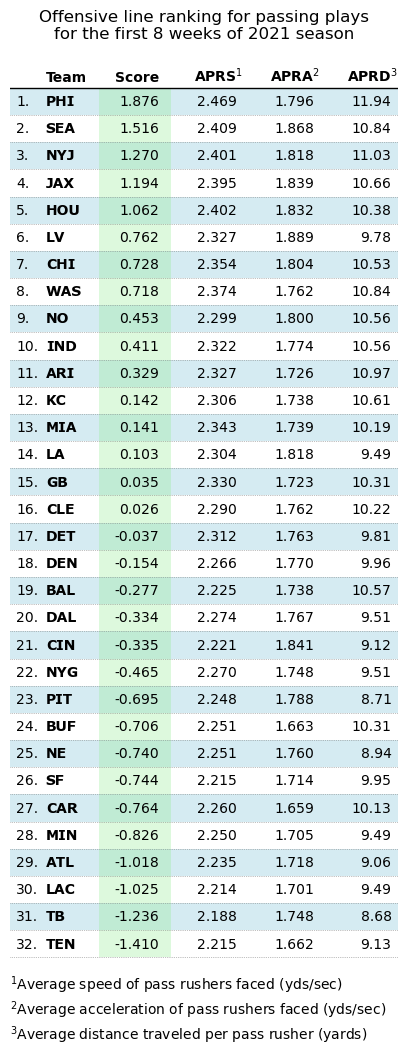

In [26]:
fig, ax = plt.subplots(figsize=(5, 12))
nrows = len(offensive_team_scores)
ncols = 6
ax.set_ylim(-1, nrows+1)
ax.set_xlim(0, ncols+0.5)

#for i, (t, v) in enumerate(order_table.items()):
for i, (v, t) in enumerate(sorted(offensive_team_scores.items(), reverse=True)):
    ax.text(x=0.1, y=nrows-1-i, s=f'{i+1}.', va='center', ha='left')
    ax.text(x=0.6, y=nrows-1-i, s=t, va='center', ha='left', fontfamily='Verdana', fontweight='bold')
    ax.text(x=2.5, y=nrows-1-i, s='{:.3f}'.format(v), va='center', ha='right')
    ax.text(x=3.8, y=nrows-1-i, s='{:.3f}'.format(offensive_team_stats[t][0]), va='center', ha='right')
    ax.text(x=5.1, y=nrows-1-i, s='{:.3f}'.format(offensive_team_stats[t][1]), va='center', ha='right')
    ax.text(x=6.4, y=nrows-1-i, s='{:.2f}'.format(offensive_team_stats[t][2]), va='center', ha='right')

# Column headers
ax.text(x=0.6, y=31.75, s='Team', weight='bold', ha='left')
ax.text(x=2.5, y=31.75, s='Score', weight='bold', ha='right')
ax.text(x=3.9, y=31.75, s='APRS$^1$', weight='bold', ha='right')
ax.text(x=5.2, y=31.75, s='APRA$^2$', weight='bold', ha='right')
ax.text(x=6.5, y=31.75, s='APRD$^3$', weight='bold', ha='right')
ax.text(x=0, y=-3.5, s=('$^1$Average speed of pass rushers faced (yds/sec)\n'
                        '$^2$Average acceleration of pass rushers faced (yds/sec)\n'
                        '$^3$Average distance traveled per pass rusher (yards)'))

for y in range(0, nrows, 2):
    row_bg = patches.Rectangle((0, 0.5+y), ncols+1, 1.0, ec='none', fc='lightblue', alpha=0.5)
    ax.add_patch(row_bg)

col_bg = patches.Rectangle((1.5, -0.5), 1.2, 32.0, ec='none', fc='lightgreen', alpha=0.3)
ax.add_patch(col_bg)

for r in range(nrows):
    ax.plot([0, ncols+1], [r-0.5, r-0.5], ls=':', lw='0.5', c='grey')
ax.plot([0, ncols+1], [31.5, 31.5], lw='1', c='black')
ax.axis('off')
plt.title('Offensive line ranking for passing plays\nfor the first 8 weeks of 2021 season')
plt.show()